# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler

import datetime

# Tabular data

## Load data

In [2]:
# Load the Excel file
file_path = 'houses.csv' 
df = pd.read_csv(file_path)

# Display the first few rows of the data
df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


## Preprocessing

### Drop useless columns

In [3]:
df = df.drop(columns=['street', 'citi'])

In [4]:
df.head()

,image_id,n_citi,bed,bath,sqft,price
0,0,317,3,2.0,1560,201900
1,1,48,3,2.0,713,228500
2,2,152,3,1.0,800,273950
3,3,48,3,1.0,1082,350000
4,4,55,4,3.0,2547,385100


### Scale features

In [5]:
# Identify the tabular features to scale
tabular_features = ['n_citi', 'bed', 'bath', 'sqft']

# StandardScaler for standardization (mean=0, std=1)
scaler = StandardScaler()

# Fit and transform the tabular features
df[tabular_features] = scaler.fit_transform(df[tabular_features])
df.head()

,image_id,n_citi,bed,bath,sqft,price
0,0,0.893504,-0.489366,-0.472771,-0.598761,201900
1,1,-1.500387,-0.489366,-0.472771,-1.424855,228500
2,2,-0.574868,-0.489366,-1.515838,-1.340002,273950
3,3,-1.500387,-0.489366,-1.515838,-1.064963,350000
4,4,-1.438092,0.477001,0.570296,0.363878,385100


### Plotting

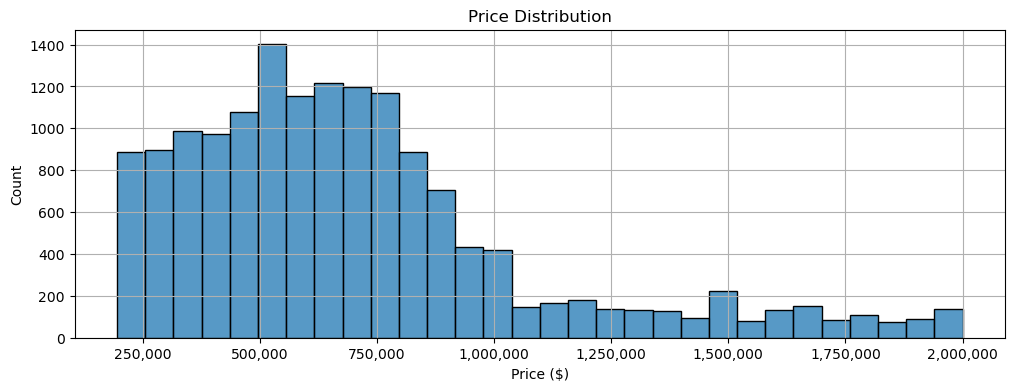

In [6]:
plt.figure(figsize=(12, 4))
ax = sns.histplot(data=df, x='price', bins=30)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.grid(True)

# Force plain numeric labels
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Image data

In [7]:
images = []

# The table has refrences to the image names
for index, row in df.iterrows():
    image_id = int(round(row['image_id']))
    image = cv2.imread('houses/' + str(image_id) + '.jpg')
    images.append((image_id, image))
    
print(len(images))

15474


## Dealing with varying shapes

### Value counts

In [8]:
# Count occurrences of each shape
shape_counts = Counter(image[1].shape for image in images)

# Print each unique shape and its count
for shape, count in shape_counts.items():
    print(f"Shape: {shape}, Count: {count}")

Shape: (350, 350, 3), Count: 170
Shape: (311, 415, 3), Count: 15297
Shape: (350, 525, 3), Count: 7


### Drop images that don't match the target shape

In [9]:
# Target shape
target_shape = (311, 415, 3)

# List to store images
images_to_keep = []

# Drop images that don't match the target shape (from df and from images list)
for image_index, image in images:
    if image.shape == target_shape: 
        images_to_keep.append((image_index, image))
    else:
        df = df[df['image_id'] != image_index]

# Update the images list to only keep valid ones
images = images_to_keep

### Value counts

In [10]:
# Count occurrences of each shape
shape_counts = Counter(image[1].shape for image in images)

# Print each unique shape and its count
for shape, count in shape_counts.items():
    print(f"Shape: {shape}, Count: {count}")

print("Df:", df.shape[0])

Shape: (311, 415, 3), Count: 15297
Df: 15297


In [11]:
assert df.shape[0] == count

# Changing image_id column for ease of access

In [12]:
df['image'] = "houses_preprocessed/" + df['image_id'].astype(str) + ".jpg"
df = df.drop("image_id", axis=1)
df['image'].head()

1    houses_preprocessed/1.jpg
2    houses_preprocessed/2.jpg
3    houses_preprocessed/3.jpg
4    houses_preprocessed/4.jpg
5    houses_preprocessed/5.jpg
Name: image, dtype: object

# Saving Data

### Save tabular data

In [13]:
df.to_csv('houses_preprocessed.csv', index=False)

### Save image data

In [14]:
# Create the directory if it doesn't exist
os.makedirs("houses_preprocessed", exist_ok=True)

# Save each image with its index as the filename
for image_index, image in images:
    filename = f"houses_preprocessed/{image_index}.jpg"
    cv2.imwrite(filename, image) 